In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.signal import correlate, fftconvolve, correlate
from scipy.stats import norm, kendalltau, spearmanr, pearsonr
from scipy.optimize import curve_fit


In [58]:
def add_noise(flux, SNR=300):
    """
    SNR = flux/sigma
    """
    noise_level = np.min(flux) / SNR
    noise = np.random.normal(0, noise_level, size=flux.shape)
    return flux + noise


def shift_array(arr, n, fill_value=0):
    """Shift an array by n elements (left or right)."""
    result = np.empty_like(arr)
    if n > 0:
        result[:n] = fill_value
        result[n:] = arr[:-n]
    elif n < 0:
        result[n:] = fill_value
        result[:n] = arr[-n:]
    else:
        result[:] = arr
    return result


def detect_molecule(wavelength, spectrum, specie_spectrum, clip_min=4.9, clip_max=27.5, peak_shift=0, window=300,
                    exclude=20):
    if len(wavelength) != len(spectrum) | len(wavelength) != len(specie_spectrum):
        print('Error: wavelength, spectrum and specie_spectrum must be the same length')
        return

    feature_mask = np.logical_and(wavelength > clip_min, wavelength < clip_max)

    # center_index = len(wavelength[feature_mask]) // 2

    lags = np.arange(-len(spectrum[feature_mask]) + 1, len(spectrum[feature_mask]))
    cc = correlate(spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac = correlate(specie_spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac /= ac[len(ac) // 2]
    center_index = len(lags) // 2
    lag_indices = np.arange(center_index - window, center_index + window + 1)

    X = ac[lag_indices]
    Y = cc[lag_indices]
    X = shift_array(X, peak_shift)

    lags_window = lags[lag_indices] - lags[center_index + peak_shift]
    noise_mask = (lags_window < -exclude) | (lags_window > exclude)

    weights = np.exp(-(lags_window) ** 2 / 2)
    # print(weights)
    factor = np.sum(weights[~noise_mask]*X[~noise_mask]*Y[~noise_mask])/np.sum(weights[~noise_mask]*X[~noise_mask]**2)
    model = factor * X
    residual = Y - model


    sigma_noise = np.std(residual[noise_mask])

    Z = factor / sigma_noise
    p = 1 - norm.cdf(Z)
    plt.plot(lags_window, Y, label='Cross-correlation')
    plt.plot(lags_window, model, label='Fitted tiny signal')
    plt.plot(lags_window, residual, label='Residual')
    plt.axvline(peak_shift, color='gray', linestyle='--', label='Peak')
    plt.axhline(0, color='gray', linestyle=':')
    plt.axvline(-exclude, color='red', linestyle='--')
    plt.axvline(exclude, color='red', linestyle='--')
    plt.title(f'Cross-correlation Analysis\nZ-score at lag=0 = {Z:.2f}')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.legend()
    # plt.xlim(-exclude, exclude)
    plt.grid(True)
    return Z, p

In [4]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)
print(df.columns)

Index(['Model Name', 'C Value', 'O Value', 'CO Value', 'FLiTs Wavelength',
       'FLiTs Flux', 'FLiTs Flux Continuum', 'FLiTs atomic Flux',
       'FLiTs atomic Wavelength', 'FLiTs C2H2 Flux', 'FLiTs C2H2 Wavelength',
       'FLiTs CH4 Flux', 'FLiTs CH4 Wavelength', 'FLiTs CO Flux',
       'FLiTs CO Wavelength', 'FLiTs CO2 Flux', 'FLiTs CO2 Wavelength',
       'FLiTs H2O Flux', 'FLiTs H2O Wavelength', 'FLiTs HCN Flux',
       'FLiTs HCN Wavelength', 'FLiTs NH3 Flux', 'FLiTs NH3 Wavelength',
       'FLiTs NO Flux', 'FLiTs NO Wavelength', 'FLiTs O2 Flux',
       'FLiTs O2 Wavelength', 'FLiTs OH Flux', 'FLiTs OH Wavelength'],
      dtype='object')


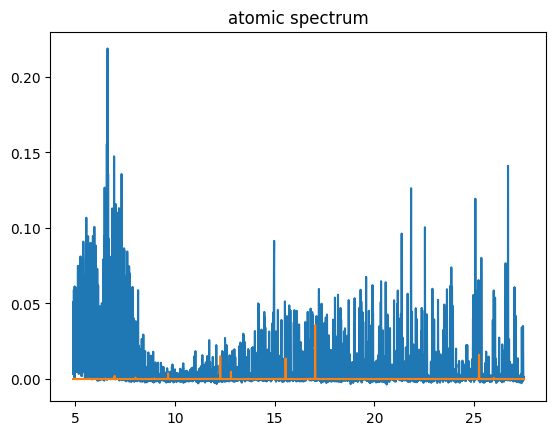

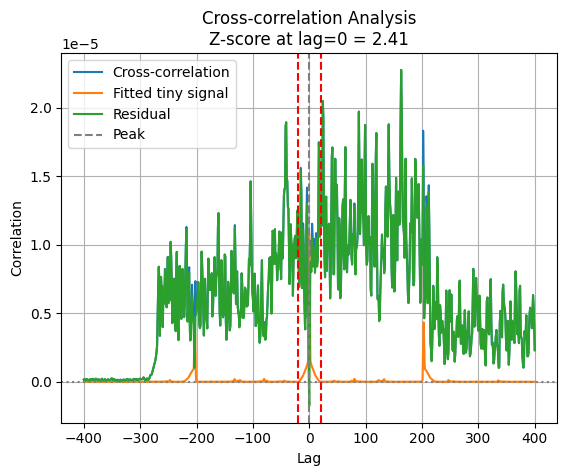

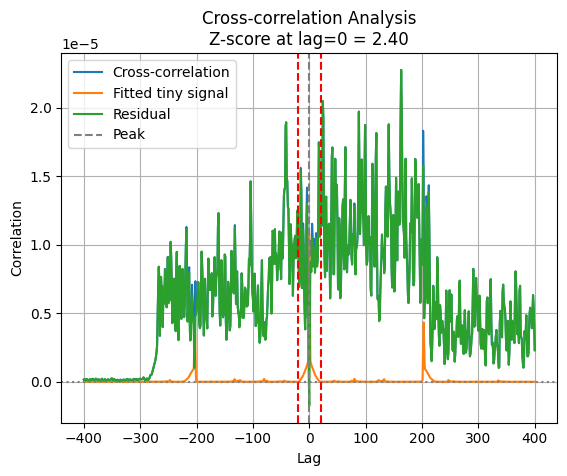

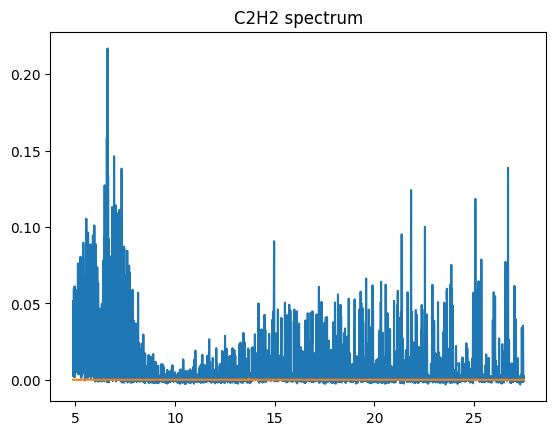

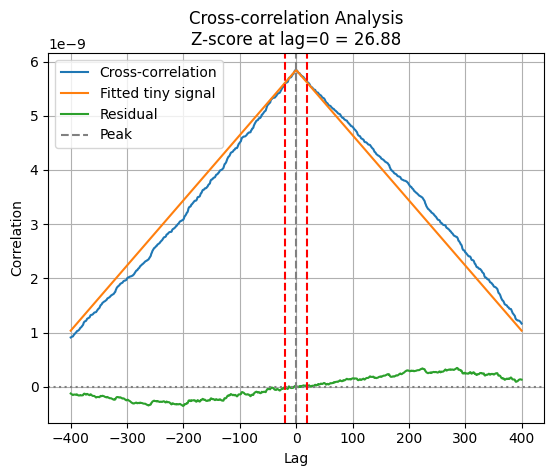

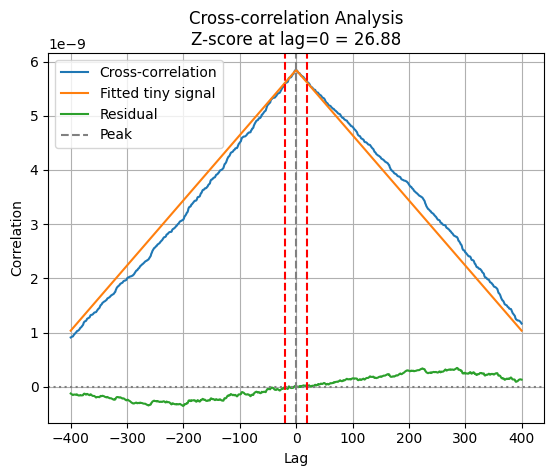

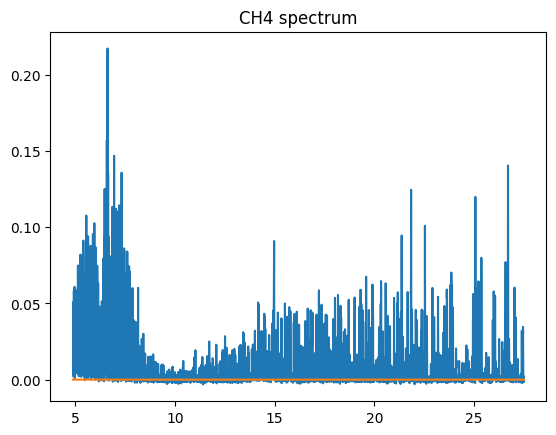

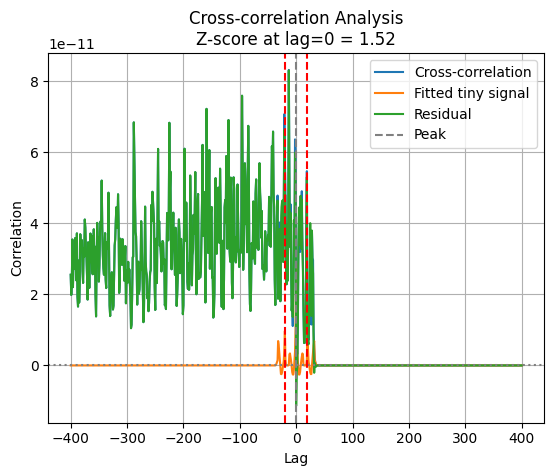

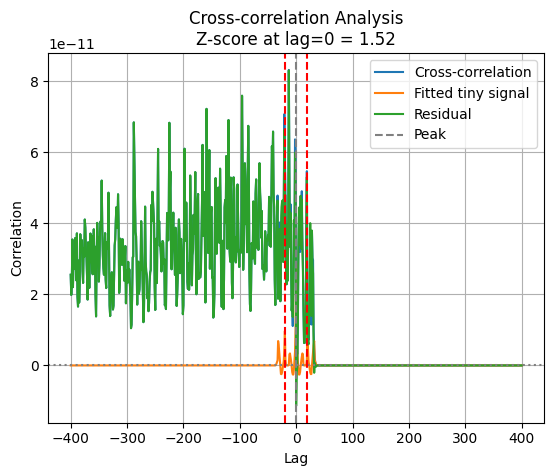

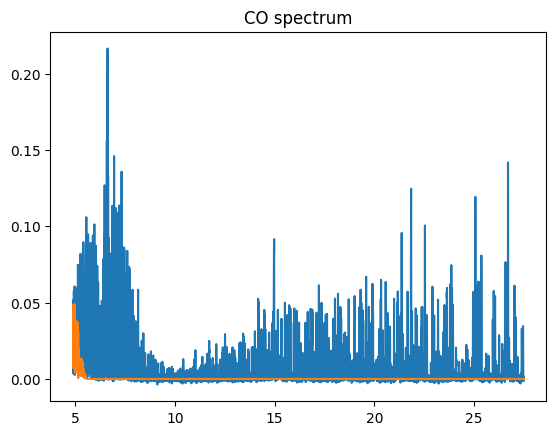

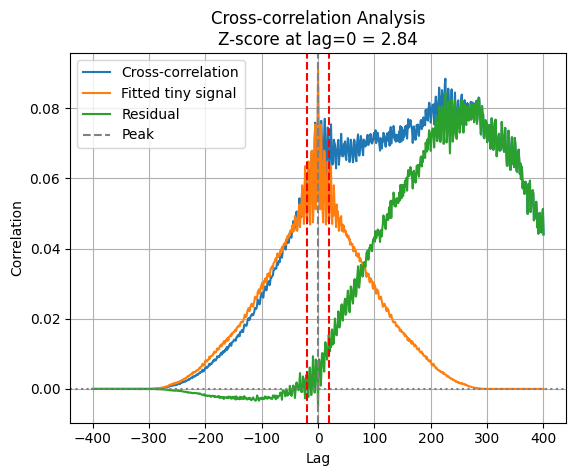

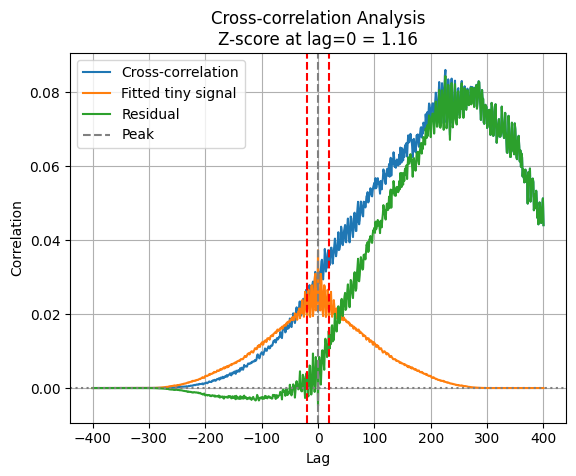

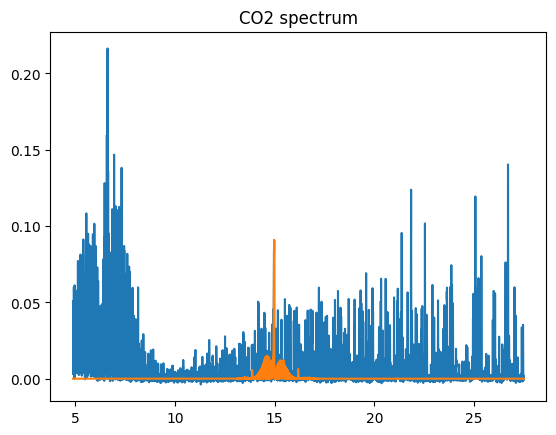

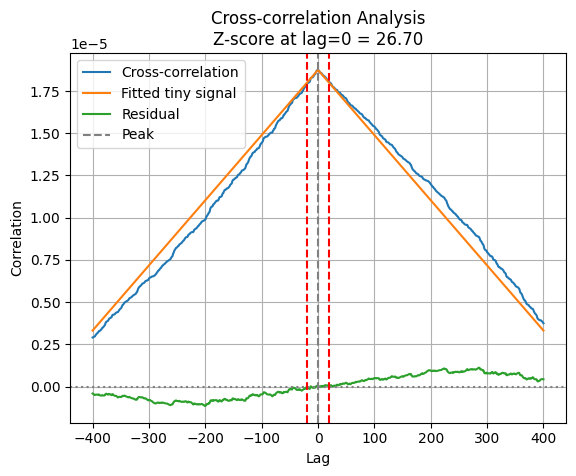

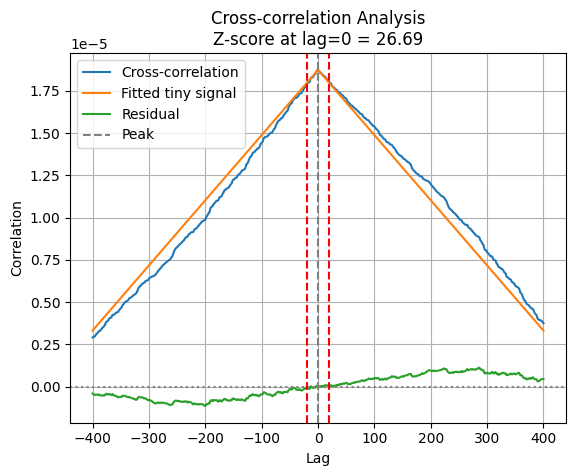

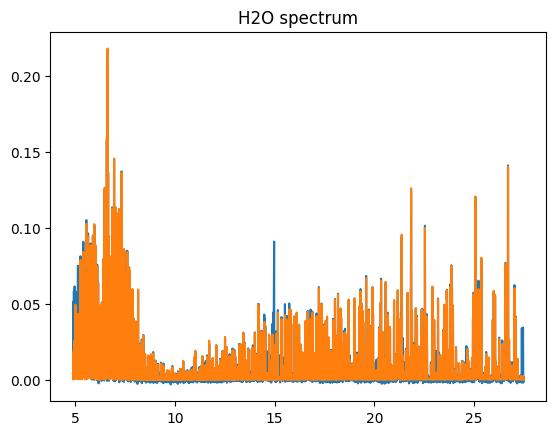

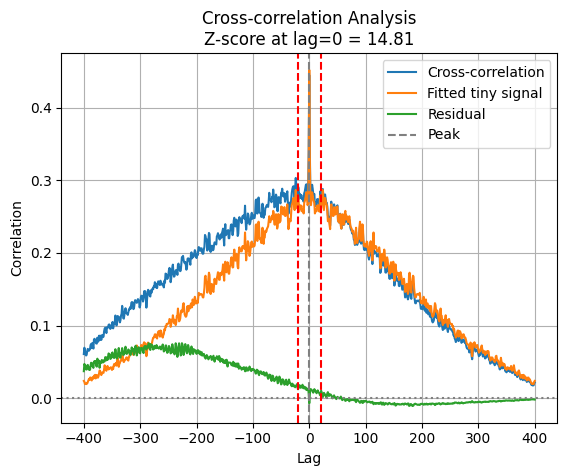

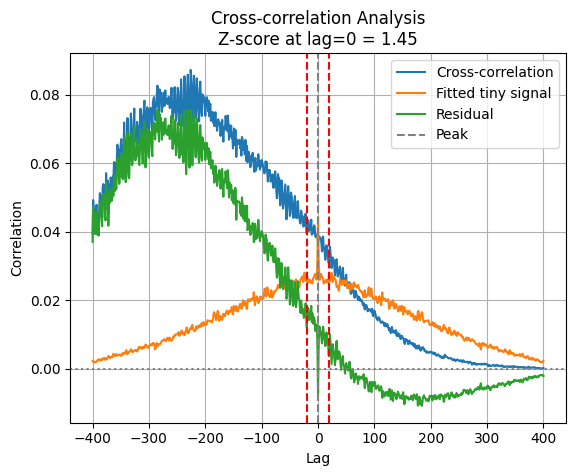

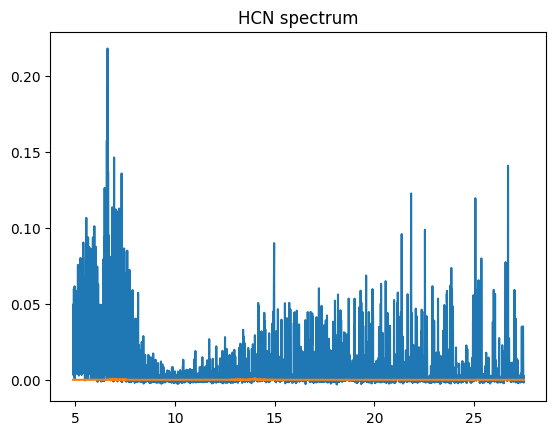

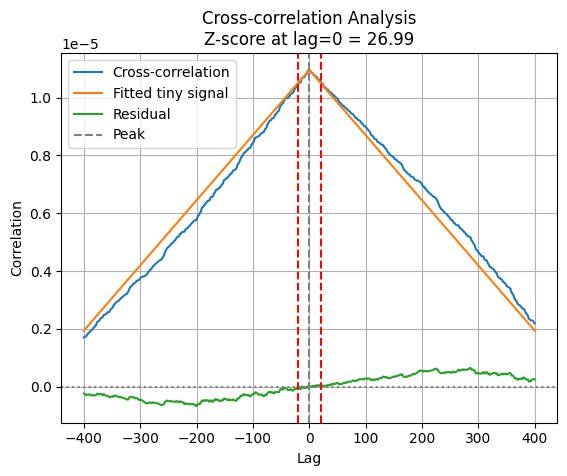

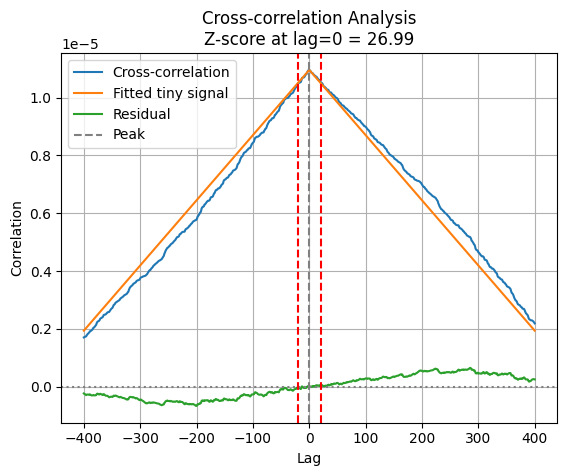

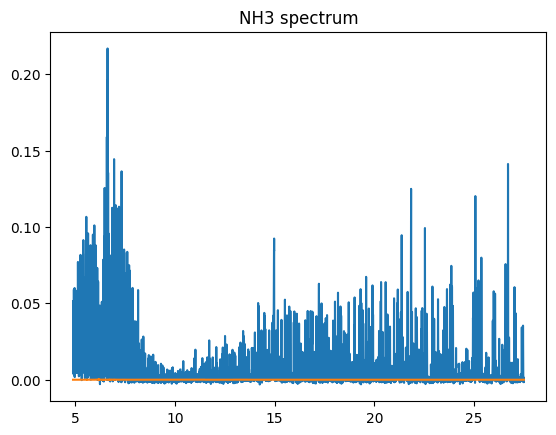

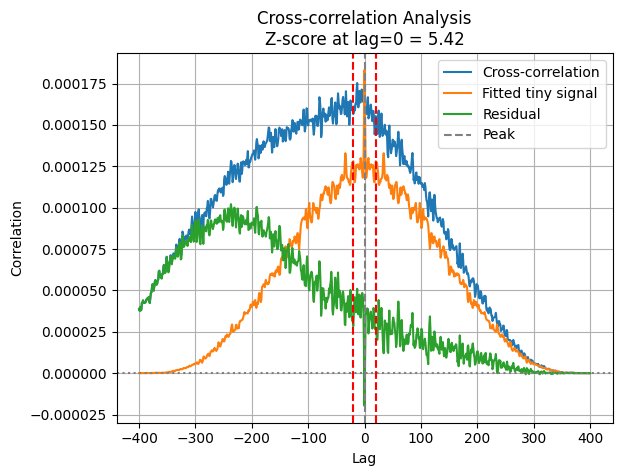

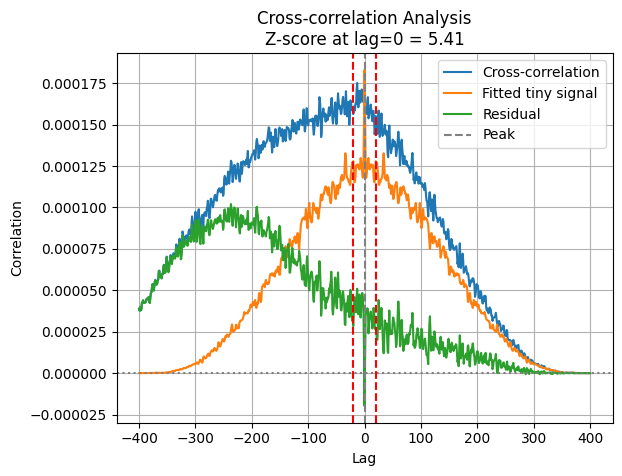

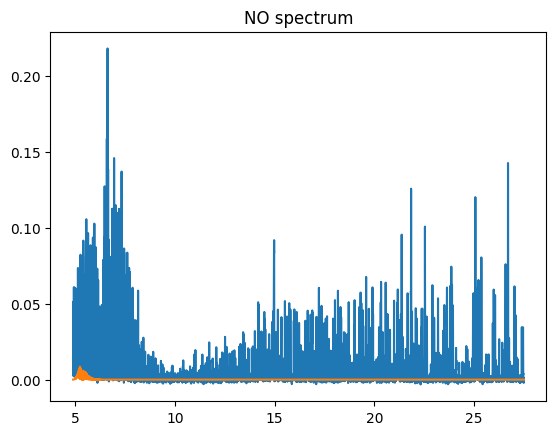

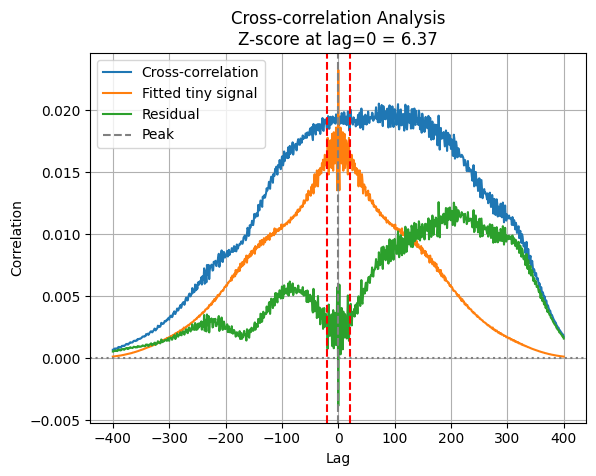

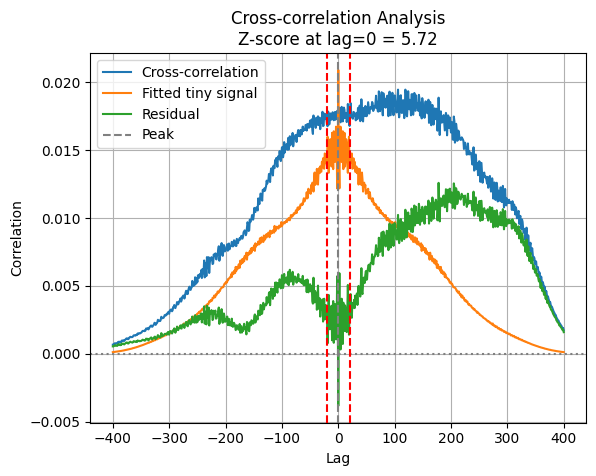

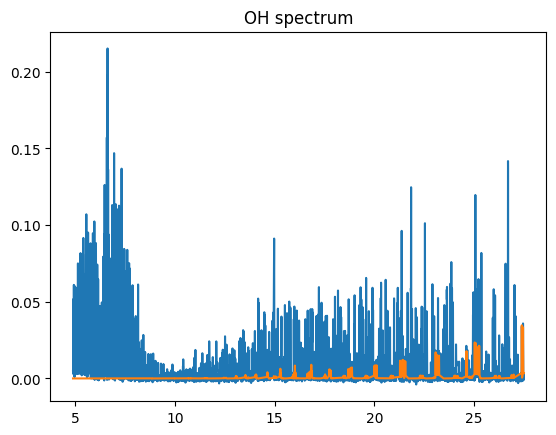

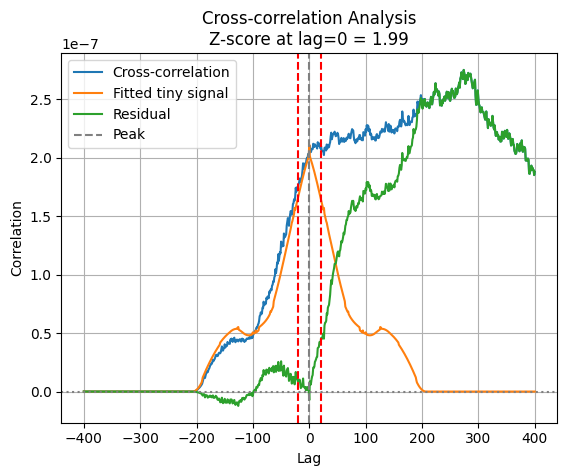

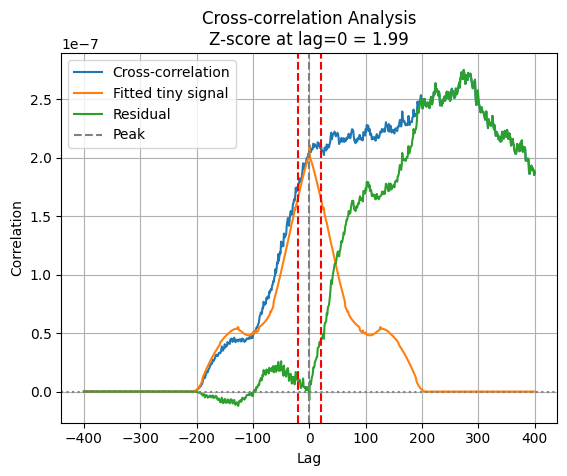

In [60]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
target = 'CO2'
total_wl = np.linspace(4.9, 27.5, 10000)
clip_min, clip_max = 4.9, 6
for target in species:
    for i, row in df.iterrows():
        if i != 12:
            continue
        wavelength = row['FLiTs Wavelength']
        flux_cont_sub = row['FLiTs Flux']
        continuum = row['FLiTs Flux Continuum']
        flux_cont_sub = np.interp(total_wl, wavelength, flux_cont_sub)
        continuum = np.interp(total_wl, wavelength, continuum)
        flux_cont_sub = add_noise(flux_cont_sub + continuum, SNR=300) - continuum
        target_wl = row[f'FLiTs {target} Wavelength']
        target_flux = row[f'FLiTs {target} Flux']
        target_flux = np.interp(total_wl, target_wl, target_flux)
        plt.plot(total_wl, flux_cont_sub)
        plt.plot(total_wl, target_flux)
        plt.title(f'{target} spectrum')
        plt.show()
        detect_molecule(total_wl, flux_cont_sub, target_flux, clip_min=clip_min, clip_max=clip_max, peak_shift=0,
                        window=400,
                        exclude=20)
        plt.show()
        detect_molecule(total_wl, flux_cont_sub - target_flux, target_flux, clip_min=clip_min, clip_max=clip_max,
                        peak_shift=0, window=400,
                        exclude=20)
        plt.show()